# Partie 3/3 : Apprentissage actif pour les données textuelles + TP

François HU - Data scientist au DataLab de la Société Générale Assurances - *19/11/19*

https://nbviewer.jupyter.org/github/curiousML/DSA/tree/master/text_mining/

In [2]:
from IPython.display import HTML, Image
HTML('''<script>code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();}code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="cacher / afficher code"></form>''')

In [12]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Contexte et objectifs

- **Classifier automatiquement des données textuelles volumineuses** : ces données sont labellisées par des experts humain (dans la littérature : "**oracles**")

Processus classique d'apprentissage statistique passif (**passive machine learning**) :

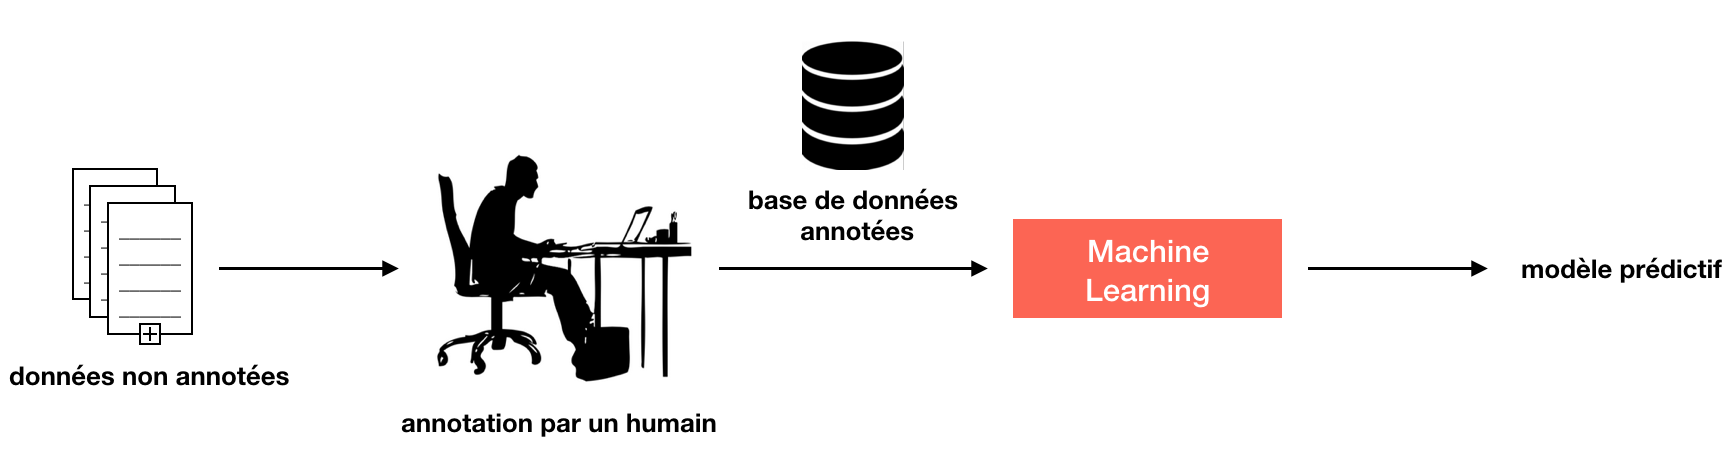

In [5]:
Image("img/passive_learning.png", width=600)

- **Problèmes** : processus d'annotation peut être trop **long**, trop **difficile** et/ou trop **coûteux**

- **Question** : pouvons-nous entraîner les modèles avec <font color = "red"><b>moins de données annotées</b></font> et avec <font color = "red"><b>moins d'intervention humaine</b></font> ?

## Active Learning

- <font color = "green"><b>Active Learning</b></font> : Modèle plus performant avec moins d'entraînement si nous avons la possibilité de choisir les données à entraîner

Processus d'apprentissage statistique actif (**active machine learning**) :

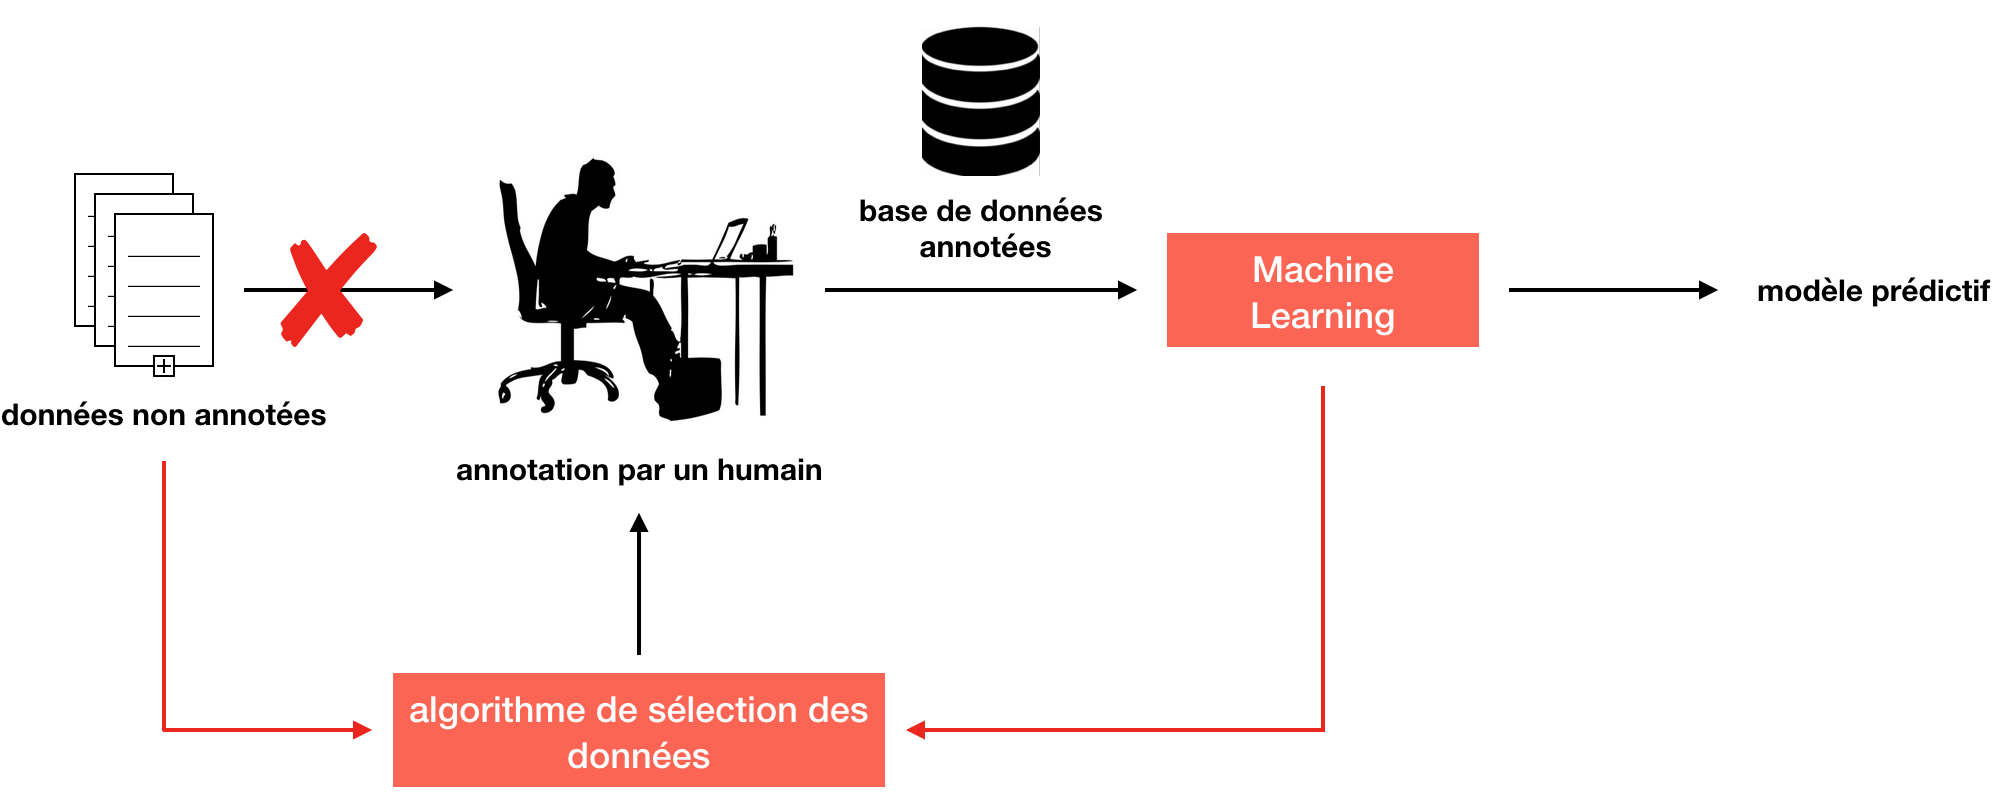

In [11]:
Image("img/active_learning.png", width=600)

- Pour l'apprenant actif (active learner), il existe différentes **stratégies de requête** pour décider la donnée la plus informative (nous voulons éviter de requêter sur des données redondantes ou non-informatives)

## Stratégies d'échantillonnage

**Notations** (supposons que nous avons un petit ensemble de données labélisées) :

- $x_A^*$ l'instance la plus informative (i.e. la meilleure requête) selon une stratégie de séléction $A$ ;

- $\mathcal{L} = \{x_i^*, y_i\}_{i = 1, \cdots, |\mathcal{L}|} $, l'ensemble des données labellisées ;

- $\mathcal{U} = \{x_i\}_{i = 1, \cdots, |\mathcal{U}|}$, l'ensemble des données non labellisées ;

- $\theta$, le modèle actuel ;

- $\mathcal{C}$, l'ensemble des labels. Dans le cas binaire, les classes 0 et 1 (ou -1 et 1) sont souvent utilisées

nous allons voir **deux stratégies classiques** : échantillonnage **basé sur l'incertitude du modèle** et échantillonnage **basé sur le désaccord des modèles**

### Echantillonnage basé sur l'incertitude (Uncertainty-based sampling)

**Echantillonnage "*least confident*"**

- L'apprenant actif requête les instances pour lesquelles il n'est pas certain comment labelliser (Lewis and Gale, 1994).

- Dans le cas d'un problème de :
    - **classification binaire**, l'échantillonnage incertain requête les instances où leur probabilité à posteriori d'être positif est proche de 0.5
    
    - **classification multi-classe**, l'échantillonnage incertain requête les instances où leur prédiction est la moins confiante
    
    $$x_{LC}^* = \arg\max_{x \in \mathcal{U}}\left\{ 1 - P_{\theta}(\hat{y} \ | \ x)\right\}$$
    
    où $\hat{y} = \arg\max\limits_{y}\left\{ P_{\theta}(y\ |\ x)\right\}$ est la classe avec la plus grande probabilité à postériori sous le modèle $\theta$.

**Echantillonnage avec marge**

- (Scheffer et al, 2001) propose une stratégie pour remédier ce problème : l'**échantillonnage avec marge** (**margin sampling**)

    $$x_{M}^* = \arg\max_{x \in \mathcal{U}}\left\{ P_{\theta}(\hat{y_1} \ | \ x) - P_{\theta}(\hat{y_2} \ | \ x)\right\}$$
    
    où $\hat{y_i}$ est la $i$-ème plus probable classe à postériori sous le modèle $\theta$.
    
    
- L'apprenant est donc :
    - **plus certain** pour les données avec de **grandes marges** car il y a une grande différence de probabilité
    - **moins certain** sur les **petites marges**
    
- Cette stratégie aide l'apprenant à discriminer entre deux classes les plus probables mais cette approche continue d'ignorer la distribution des sorties pour les classes restantes (et cela peut poser problème si nous avons un très grand ensemble de labels)

**Echantillonnage par entropie**

- Une stratégie d'échantillonnage incertain plus générale (Shannon, 1948) utilise l'**entropie** comme mesure d'incertitude

    $$x_{H}^* = \arg\max_{x \in \mathcal{U}}\left\{ - \sum\limits_{i=1}^{|\mathcal{C}|}P_{\theta}(y_i \ | \ x)\log P_{\theta}(y_i \ | \ x)\right\}$$
    
    
- Une entropie est une mesure d'information théorique qui représente la quantité d'information nécessaire pour "encoder" une distribution

- Pour une classification binaire, les trois stratégies ci-dessus sont équivalentes

- Pour une classification multi-classe, l'approche entropique se généralise bien (voir Setteles et Craven (2008), pour les travaux sur les séquences)

- Intuitivement :
    - l'entropie semble être plus appropriée si la fonction objectif est de minimiser la **perte logistique** (**log-loss**)
    - l'échantillonnage incertain et l'échantillonnage de marge semblent plus appropriées si nous voulons réduire l'**erreur de classification** (**accuracy**).

### Echantillonnage basé sur le désaccord (Query by committee)

- L'approche QBC (Seung et al., 1992) consiste à **mettre en place, entraîner et maintenir** plusieurs modèles d'apprenant $\Theta = \{\theta^{(1)},\cdots, \theta^{(N)} \}$.

- Pour $i\in\{1, \cdots, C\}$, chaque modèle $\theta^{(i)}$ peut voter sur le label de chaque candidat de la requête

- La requête la plus informative est l'**instance où les modèles sont le plus en désaccord**

- **Objectif en apprentissage :** donner le meilleur modèle dans l'espace de versions. **Objectif en apprentissage actif :** contraindre le plus possible la taille de l'espace avec le moins d'instances labellisées que possible.

- Afin d'implémenter un algorithme de séléction QBC nous devons préalablement :
    1. construire un comité de modèles qui représentent différentes régions de l'espace des versions (Mitchelle, 1982). 
    2. avoir une mesure de désaccord parmi les membres du comité  


- Cependant, il ne semble <u>pas avoir de méthode idéale</u>, <u>ni un nombre optimal de membres</u> à utiliser, car les résultats dépendent fortement de l'application.

## TP : Active learnig

In [1]:
from IPython.display import HTML, Image
HTML('''<script>code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();}code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="cacher / afficher code"></form>''')

In [ ]:
# nous allons importer les librairies
import os
import pandas as pd
import numpy as np
import time
import string
from tqdm import tqdm
import nltk
import gensim

# nous importons aussi les package pour le preprocessing
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("snowball_data")

# nous allons charger les donnees dans un pandas dataframe
def load_data(data_dir_path_str, dataset_type):
    """
    This function loads the data from the IMBD dataset.
    --------------------------------------------------------------------------------
    Arguments:
    --------------------------------------------------------------------------------
    data_dir_path_str: string
            Path where the data folder is located.
    dataset_type: string, either "train" or "test"
            Dataset we want to load: either train or test.
    --------------------------------------------------------------------------------
    Returns:
    --------------------------------------------------------------------------------
    data_df: Pandas DataFrame
            Pandas DataFrame with two columns:
             - review: Contains the text of the IMDB review.
             - target: Contains the associated label, either 0 for negative review 
               and 1 for positive ones.
    """
    # Start a stopwatch to measure the time taken by the function to execute itself.
    start_time = time.time()
    
    train_dir = os.path.join(data_dir_path_str, dataset_type)
    labels = []
    texts = []

    # For each label, load associated reviews
    for label_type in ["neg", "pos"]:
        dir_name = os.path.join(train_dir, label_type)
        print("Loading data for", label_type, "reviews...")
        for fname in tqdm(os.listdir(dir_name)):
            if fname[-4:] == ".txt":
                f = open(os.path.join(dir_name, fname), "r", encoding = "utf-8")
                texts.append(f.read())
                f.close()
                if label_type == "neg":
                    labels.append(0)
                else:
                    labels.append(1)
    
    data_df = pd.DataFrame({"review": texts, "target": labels})
    
    print(data_df.shape[0], "samples loaded in", round(time.time() - start_time, 3), "secs")
    
    return data_df

# Chemin du repertoire du dossier "sclImbd"
imbd_dir = "/Users/Faugon/Desktop/2_These/analyse_bibliographique/active_learning/aclImdb"

# Charger et melanger les donnees
train_valid_data_df = load_data(imbd_dir, "train").sample(frac = 1).reset_index(drop = True)
test_data_df        = load_data(imbd_dir, "test").sample(frac = 1).reset_index(drop = True)